In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from glob import glob
from os import path

In [3]:
data_paths = glob('./data/*.csv')
data_train_paths = [s for s in data_paths if "train" in path.basename(s)]
dataset = []
for train_path in data_train_paths:
    d_train = np.array(pd.read_csv(train_path))
    d_test = np.array(pd.read_csv(train_path.replace('train', 'test')))
    dataset.append([d_train[:,:-1], d_train[:, -1], d_test[:,:-1], d_test[:, -1]])

In [4]:
def plot_depths_accuracy(data, max_depth=20, title=None, show=True, legend=None):
    X_train, y_train, X_test, y_test = data
    scores = []
    for depth in range(1, max_depth+1):
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    plt.plot(range(1, max_depth+1), scores, label=legend)
    plt.ylim(0,1.05)
    plt.xticks(range(0, max_depth+1, max_depth//10))
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    plt.title(title)
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    if show:
        plt.show()

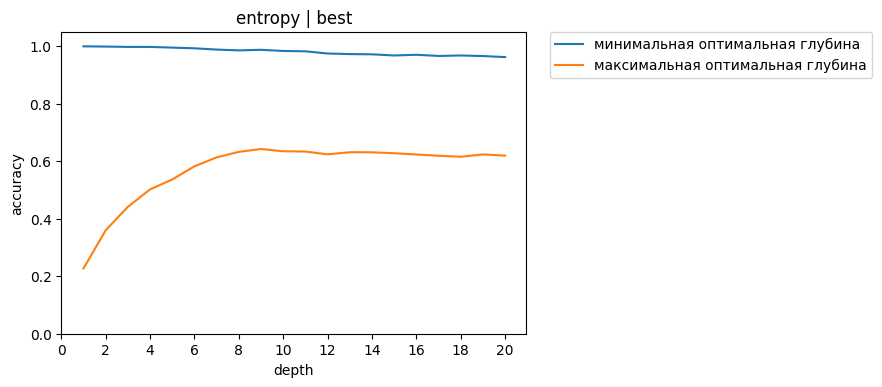

In [23]:
# for criterion in ['gini', 'entropy']:
#     for splitter in ['best', 'random']:
criterion = 'entropy'
splitter = 'best'
top_scores = []
for data in dataset:
    X_train, y_train, X_test, y_test = data
    scores = []
    for depth in range(1, 500):
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
        if len(scores) > 1 and scores[-1] < scores[-2]:
            top_scores.append(depth-1)
            break

min_index = top_scores.index(min(top_scores))
max_index = top_scores.index(max(top_scores))

plt.figure(dpi=100)
plot_depths_accuracy(
    dataset[min_index],
    legend="минимальная оптимальная глубина",
    show=False
)
plot_depths_accuracy(
    dataset[max_index],
    title='%s | %s' % (criterion, splitter),
    legend="максимальная оптимальная глубина",
    show=True
)

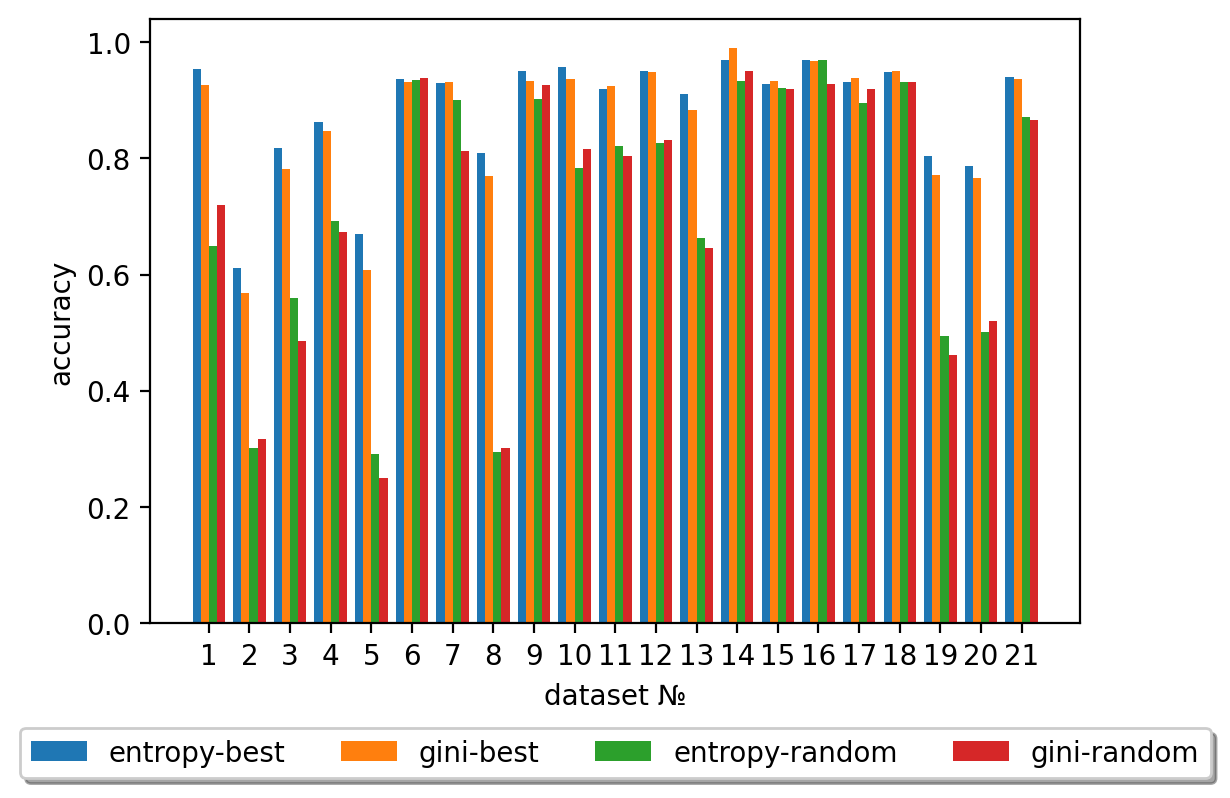

In [36]:
x =np.arange(1, len(dataset)+1)
width = 0.2
shift = 1.5
plt.figure(dpi=200)

for splitter in ['best', 'random']:
    for criterion in ['entropy', 'gini']:
        scores = []
        for data in dataset:
            X_train, y_train, X_test, y_test = data

            clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
            clf.fit(X_train, y_train)
            scores.append(clf.score(X_test, y_test))
        plt.bar(x - width*shift, scores, width=width, label="%s-%s" % (criterion, splitter))
        shift -= 1
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)
plt.xticks(x)
plt.ylabel('accuracy')
plt.xlabel('dataset №')
plt.show()

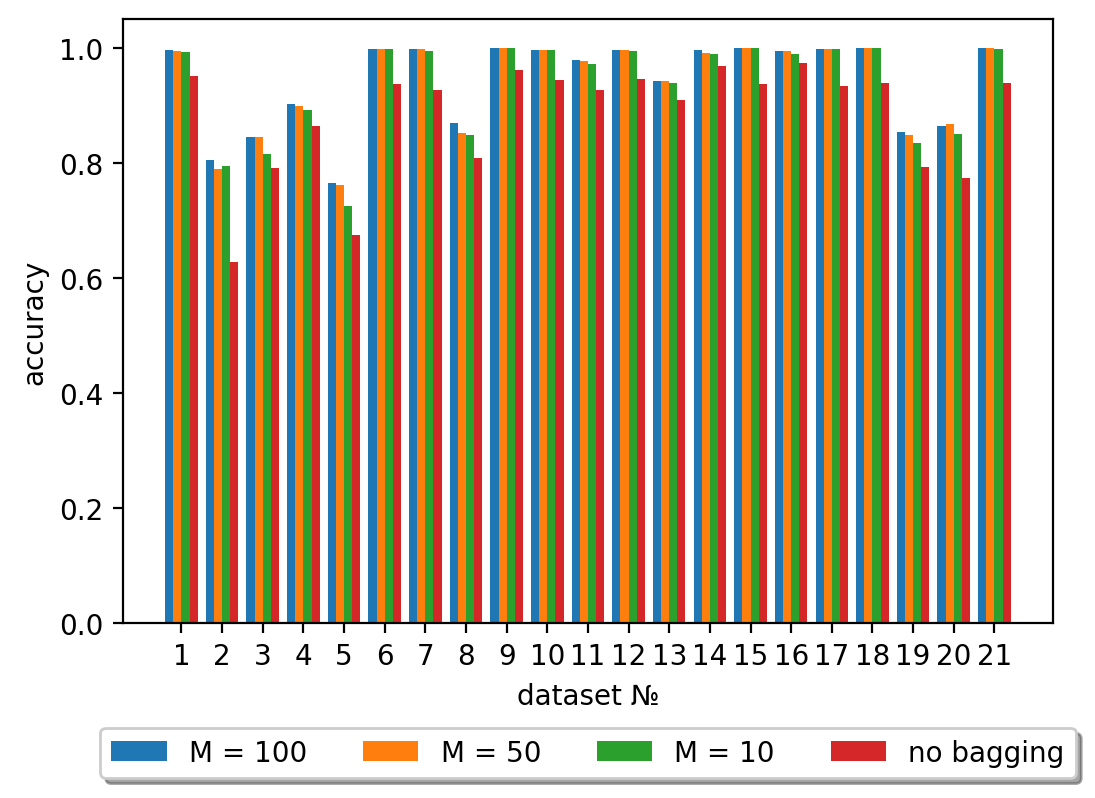

In [37]:
x =np.arange(1, len(dataset)+1)
width = 0.2
shift = 1.5
plt.figure(dpi=200)
criterion = 'entropy'
splitter = 'best'

for M in [100, 50, 10]:
    bagging_scores = []
    scores = []
    for data in dataset:
        X_train, y_train, X_test, y_test = data

        clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))

        preds = np.empty((0, y_test.size))
        for i in range(M):
            train_indexes = np.random.randint(y_train.size, size=y_train.size)
            X_train_bag, y_train_bag = (X_train[train_indexes], y_train[train_indexes])
            clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
            clf.fit(X_train_bag, y_train_bag)
            preds = np.append(preds, clf.predict(X_test)[None], axis=0)

        pred = np.array(np.apply_along_axis(lambda a: max(map(lambda val: ((a == val).sum(), val), set(a)))[1], 0, preds))
        bagging_scores.append((pred == y_test).sum()/y_test.size)

    plt.bar(x - width*shift, bagging_scores, width=width, label="M = %d" % M)
    shift -= 1
plt.bar(x - width*shift, scores, width=width, label="no bagging")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)
plt.xticks(x)
plt.ylabel('accuracy')
plt.xlabel('dataset №')
plt.show()

